# ANÁLISE DO SEGUNDO TURNO DAS ELEIÇÕES PRESIDENCIAIS DE 2022


## Considerando os seguintes itens:
* __ceft__ - Correspondências Efetivadas e Esperadas
* __vs__ - Votação por seção
* __bweb__ - BUs em CSV
* Convocação de __mesarios__

In [ ]:
!pip install pyspark
!pip install -q findspark

import findspark
findspark.init()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 40 kB/s 
     |████████████████████████████████| 199 kB 5.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845514 sha256=f4601150849cc688858309be3e3213b69ec7dc0d2bd3ab781057c16711665790
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


In [ ]:
spark.stop()

NameError: ignored

In [ ]:
#Import do os Spark, Pandas, NumPy, matplotlib e Seaborn

import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
import pandas as pd
import numpy as np
#import pyspark.pandas as ps
import string
import seaborn as sns

from matplotlib import pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
!mkdir /content/vm
!mkdir /content/bweb2T
!mkdir /content/Mesarios
!mkdir /content/vs
!mkdir /content/CEFT2T
!cp -r /content/drive/MyDrive/vm/* /content/vm
!cp -r /content/drive/MyDrive/vs/* /content/vs
!cp -r /content/drive/MyDrive/CEFT2T/* /content/CEFT2T
!cp -r /content/drive/MyDrive/bweb2T/* /content/bweb2T
!cp -r /content/drive/MyDrive/Mesarios/* /content/Mesarios 



In [ ]:
#@title
os.environ["PYSPARK_SUBMIT_ARGS"] = '--driver-memory 2g --executor-memory 2g --driver-cores 1 --executor-cores 11 pyspark-shell'

#Inicia Spark Session e configura o HTML Table do Pandas, além de definir o Path
path = "/content/drive/MyDrive" #Mude o caminho para o diretório da sua máquina ou serviço de Cloud

!mkdir /content/spark
!cp /content/drive/MyDrive/spark/getGpuResources.sh /content/spark
!chmod 755 /content/spark/getGpuResources.sh

#com GPU
spark = SparkSession.builder\
          .appName("V2T")\
          .master("local[*]")\
          .config("spark.executor.cores", "11")\
          .config("spark.driver.cores", "1")\
          .config("spark.executor.instances", "10")\
          .config("spark.ui.port", "4050")\
          .config("spark.jars", path + "/spark/rapids-4-spark_2.12-22.10.0.jar")\
          .config("spark.rapids.sql.enabled","true")\
          .config("spark.driver.resource.gpu.amount", "1")\
          .config("spark.driver.resource.gpu.discoveryScript", "/content/spark/getGpuResources.sh")\
          .config("spark.task.resource.gpu.amount", "1")\
          .config("spark.task.resource.gpu.discoveryScript", "/content/spark/getGpuResources.sh")\
          .config("spark.executor.resource.gpu.amount", "1")\
          .config("spark.executor.resource.gpu.discoveryScript", "/content/spark/getGpuResources.sh")\
          .getOrCreate()


spark.sparkContext.setLogLevel("INFO")

pd.options.display.html.table_schema=True



mkdir: cannot create directory ‘/content/spark’: File exists


ConnectionRefusedError: ignored

In [ ]:
#@title
os.environ["PYSPARK_SUBMIT_ARGS"] = '--driver-memory 32g --executor-memory 32g --driver-cores 12 --executor-cores 12 pyspark-shell'

#Inicia Spark Session e configura o HTML Table do Pandas, além de definir o Path
path = "/content/" #Mude o caminho para o diretório da sua máquina ou serviço de Cloud

#com CPU
spark = SparkSession.builder\
          .appName("V2T")\
          .master("local[*]")\
          .config("spark.executor.cores", "12")\
          .config("spark.driver.cores", "12")\
          .config("spark.executor.memory", "32g")\
          .config("spark.driver.memory", "32g")\
          .config("spark.executor.instances", "10")\
          .config("spark.ui.port", "4050")\
          .getOrCreate()


spark.sparkContext.setLogLevel("INFO")

pd.options.display.html.table_schema=True



In [ ]:
#Baixa o ngrok para poder ver a Spark UI
!wget https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
!tar xvzf /content/ngrok-v3-stable-linux-amd64.tgz


--2022-11-16 06:55:29--  https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 52.202.168.65, 18.205.222.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8413784 (8.0M) [application/octet-stream]
Saving to: ‘ngrok-v3-stable-linux-amd64.tgz’

ngrok-v3-stable-lin 100%[===================>]   8.02M  28.7MB/s    in 0.3s    

2022-11-16 06:55:29 (28.7 MB/s) - ‘ngrok-v3-stable-linux-amd64.tgz’ saved [8413784/8413784]

ngrok


In [ ]:
#Autentica ngrok com o seu authtoken e abre o servidor
!/content/ngrok config add-authtoken 2Hc5CCZKmrlRX7DyJoagQUgjlLz_6hamTwFLgGygo22FfWvDY
get_ipython().system_raw('./ngrok http 4050 &')

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
#Pega o link do ngrok para a interface do Spark UI
!curl -s http://localhost:4040/api/tunnels

{"tunnels":[{"name":"command_line","ID":"0e716ffbb2e815ad06dac99d42ce2b61","uri":"/api/tunnels/command_line","public_url":"https://9d36-34-170-234-239.ngrok.io","proto":"https","config":{"addr":"http://localhost:4050","inspect":true},"metrics":{"conns":{"count":0,"gauge":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0},"http":{"count":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0}}}],"uri":"/api/tunnels"}


In [ ]:
!nvidia-smi --query-gpu=index --format=csv,noheader
#!apt-get install libgl1-mesa-glx libegl1-mesa libxrandr2 libxrandr2 libxss1 libxcursor1 libxcomposite1 libasound2 libxi6 libxtst6

0


In [ ]:
#Lê BUs dos arquivos CSV bweb já descomprimidos. Filtra apenas eleição para presidente.
bweb = spark.read.csv(
                    path + "/bweb2T/bweb*/*.csv", 
                    header=True, 
                    inferSchema=True, 
                    encoding="ISO-8859-1", 
                    sep=";")\
            .filter("CD_CARGO_PERGUNTA = 1")

In [ ]:
#Lê Resultado por seção do arquivo CSV já descomprimido. Filtra apenas 2o turno.
vs = spark.read.csv(
                    path + "/vs/*.csv", 
                    header=True, 
                    inferSchema=True, 
                    encoding="ISO-8859-1", sep=";")\
            .filter("NR_TURNO = 2")

In [ ]:
#Lê resultados dos arquivos de Correspondências Efetivadas do segundo turno já descomprimidos. 

ceft = spark.read.csv(
                    path + "/CEFT2T/*/*.csv", 
                    header=True, inferSchema=True, 
                    encoding="ISO-8859-1", sep=";")

In [ ]:
#Analisa Schema vs e contagem de registros
vs.printSchema()
vs.count()

root
 |-- DT_GERACAO: string (nullable = true)
 |-- HH_GERACAO: timestamp (nullable = true)
 |-- ANO_ELEICAO: integer (nullable = true)
 |-- CD_TIPO_ELEICAO: integer (nullable = true)
 |-- NM_TIPO_ELEICAO: string (nullable = true)
 |-- NR_TURNO: integer (nullable = true)
 |-- CD_ELEICAO: integer (nullable = true)
 |-- DS_ELEICAO: string (nullable = true)
 |-- DT_ELEICAO: string (nullable = true)
 |-- TP_ABRANGENCIA: string (nullable = true)
 |-- SG_UF: string (nullable = true)
 |-- SG_UE: string (nullable = true)
 |-- NM_UE: string (nullable = true)
 |-- CD_MUNICIPIO: integer (nullable = true)
 |-- NM_MUNICIPIO: string (nullable = true)
 |-- NR_ZONA: integer (nullable = true)
 |-- NR_SECAO: integer (nullable = true)
 |-- CD_CARGO: integer (nullable = true)
 |-- DS_CARGO: string (nullable = true)
 |-- NR_VOTAVEL: integer (nullable = true)
 |-- NM_VOTAVEL: string (nullable = true)
 |-- QT_VOTOS: integer (nullable = true)
 |-- NR_LOCAL_VOTACAO: integer (nullable = true)
 |-- SQ_CANDIDATO:

1850892

In [ ]:
#Analisa Schema bweb e contagem de registros

bweb.printSchema()
bweb.count()

root
 |-- DT_GERACAO: string (nullable = true)
 |-- HH_GERACAO: timestamp (nullable = true)
 |-- ANO_ELEICAO: integer (nullable = true)
 |-- CD_TIPO_ELEICAO: integer (nullable = true)
 |-- NM_TIPO_ELEICAO: string (nullable = true)
 |-- CD_PLEITO: integer (nullable = true)
 |-- DT_PLEITO: string (nullable = true)
 |-- NR_TURNO: integer (nullable = true)
 |-- CD_ELEICAO: integer (nullable = true)
 |-- DS_ELEICAO: string (nullable = true)
 |-- SG_UF: string (nullable = true)
 |-- CD_MUNICIPIO: integer (nullable = true)
 |-- NM_MUNICIPIO: string (nullable = true)
 |-- NR_ZONA: integer (nullable = true)
 |-- NR_SECAO: integer (nullable = true)
 |-- NR_LOCAL_VOTACAO: integer (nullable = true)
 |-- CD_CARGO_PERGUNTA: integer (nullable = true)
 |-- DS_CARGO_PERGUNTA: string (nullable = true)
 |-- NR_PARTIDO: integer (nullable = true)
 |-- SG_PARTIDO: string (nullable = true)
 |-- NM_PARTIDO: string (nullable = true)
 |-- DT_BU_RECEBIDO: string (nullable = true)
 |-- QT_APTOS: integer (nullable

1850892

In [ ]:
#Analisa Schema ceft e contagem de registros

ceft.printSchema()
ceft.count()

root
 |-- DT_GERACAO: string (nullable = true)
 |-- HH_GERACAO: timestamp (nullable = true)
 |-- ANO_ELEICAO: integer (nullable = true)
 |-- CD_PLEITO: integer (nullable = true)
 |-- DT_PLEITO: string (nullable = true)
 |-- SG_UF: string (nullable = true)
 |-- CD_MUNICIPIO: integer (nullable = true)
 |-- NM_MUNICIPIO: string (nullable = true)
 |-- NR_ZONA: integer (nullable = true)
 |-- NR_SECAO: integer (nullable = true)
 |-- SQ_CORRESPONDENCIA_ESPERADA: integer (nullable = true)
 |-- NR_URNA_ESPERADA: integer (nullable = true)
 |-- CD_CARGA_URNA_ESPERADA: decimal(24,0) (nullable = true)
 |-- CD_CARGA_1_URNA_ESPERADA: string (nullable = true)
 |-- CD_CARGA_2_URNA_ESPERADA: string (nullable = true)
 |-- CD_FLASHCARD_URNA_ESPERADA: string (nullable = true)
 |-- DT_CARGA_URNA_ESPERADA: string (nullable = true)
 |-- DT_RECO_URNA_ESPERADA: string (nullable = true)
 |-- SQ_CORRESPONDENCIA_EFETIVADA: integer (nullable = true)
 |-- NR_URNA_EFETIVADA: integer (nullable = true)
 |-- CD_CARGA_UR

472027

## ENGENHARIA DE DADOS

Nesta parte do Notebook iremos trabalhar com engenharia de dados. São feitas as seguintes etapas:

1. Criação do campo urna_id, que será usado para fazer joins com ceft, vs e bweb
2. Criação do campo zona_id, que será usado para join com o dataset mesarios posteriormente
3. Criação do campo modelo a partir do número da urna
4. Ajustes dos campos de data dos mais diversos
5. Criação do campo região
6. Eliminação de campos desnecessários ou repetidos
7. Criação do campo urna_id no dataframe vs
8. Criação do campo urna_id e ajustes de data no dataframe ceft

Os dataframes são todos reparticionados pelo campo urna_id para facilitar o join e otimizar a performance.

Após essa etapa são criadas as views bweb, vs e ceft, que serão usadas para o primeiro join, que gera um novo dataframe ainda sem agrupar os dados para análise, o que será feito no próximo quadro.

Como iremos agrupar esse dataset, já foi utilizada a função persist() do Spark para armazenar os dados na memória, facilitando os próximos passos.

In [ ]:
bweb_t = bweb\
            .withColumn("urna_id", concat_ws("-", col("CD_MUNICIPIO"), col("NR_ZONA"), col("NR_SECAO")))\
            .withColumn("zona_id", concat_ws("-", col("CD_MUNICIPIO"), col("NR_ZONA")))\
            .withColumn("modelo", expr('''
                                    CASE WHEN NR_URNA_EFETIVADA BETWEEN 999500 AND 1220500 THEN 2009
                                    WHEN NR_URNA_EFETIVADA BETWEEN 1220501 AND 1345500 THEN 2010 
                                    WHEN NR_URNA_EFETIVADA BETWEEN 1368501 AND 1370500 THEN 2011
                                    WHEN NR_URNA_EFETIVADA BETWEEN 1600000 AND 1650000 THEN 2011
                                    WHEN NR_URNA_EFETIVADA BETWEEN 1650001 AND 1701000 THEN 2013
                                    WHEN NR_URNA_EFETIVADA BETWEEN 1750000 AND 1950000 THEN 2015
                                    WHEN NR_URNA_EFETIVADA BETWEEN 2000000 AND 2250000 THEN 2020
                                    ELSE 1 END'''))\
            .withColumn("dh_geracao", expr("TO_TIMESTAMP(CONCAT_WS(' ', DT_GERACAO, HH_GERACAO), 'dd/MM/yyyy HH:mm:ss')"))\
            .withColumn("dh_emissao_bu", expr("TO_TIMESTAMP(DT_EMISSAO_BU, 'dd/MM/yyyy HH:mm:ss')"))\
            .withColumn("dh_bu_recebido", expr("TO_TIMESTAMP(DT_BU_RECEBIDO, 'dd/MM/yyyy HH:mm:ss')"))\
            .withColumn("dh_abertura", expr("TO_TIMESTAMP(DT_ABERTURA, 'dd/MM/yyyy HH:mm:ss')"))\
            .withColumn("dh_encerramento", expr("TO_TIMESTAMP(DT_ENCERRAMENTO, 'dd/MM/yyyy HH:mm:ss')"))\
            .withColumn("regiao", expr('''CASE
                                            WHEN SG_UF IN('SP', 'RJ', 'ES', 'MG') THEN 'SE'
                                            WHEN SG_UF IN('RS', 'SC', 'PR') THEN 'S'
                                            WHEN SG_UF IN('MT', 'MS', 'DF', 'GO') THEN 'CO'
                                            WHEN SG_UF IN('AM', 'PA', 'AP', 'RO', 'RR', 'TO', 'AC') THEN 'N'
                                            WHEN SG_UF = 'ZZ' THEN 'ZZ'
                                            ELSE 'NE'
                                           END as regiao'''))\
            .drop("ANO_ELEICAO")\
            .drop("NM_TIPO_ELEICAO")\
            .drop("CD_TIPO_ELEICAO")\
            .drop("DT_PLEITO")\
            .drop("NR_TURNO")\
            .drop("CD_PLEITO")\
            .drop("CD_ELEICAO")\
            .drop("DS_ELEICAO")\
            .drop("NR_PARTIDO")\
            .drop("NM_PARTIDO")\
            .drop("DS_TIPO_URNA")\
            .drop("CD_CARGO_PERGUNTA")\
            .drop("DS_CARGO_PERGUNTA")\
            .drop("DT_CARGA_URNA_EFETIVADA")\
            .drop("DS_CARGO_PERGUNTA_SECAO")\
            .drop("SG_PARTIDO")\
            .drop("NR_URNA_EFETIVADA")\
            .drop("NM_VOTAVEL")\
            .drop("CD_FLASHCARD_URNA_EFETIVADA")\
            .drop("CD_CARGA_1_URNA_EFETIVADA")\
            .drop("CD_CARGA_2_URNA_EFETIVADA")\
            .drop("CD_TIPO_VOTAVEL")\
            .drop("DT_GERACAO")\
            .drop("HH_GERACAO")\
            .drop("DT_EMISSAO_BU")\
            .drop("DT_BU_RECEBIDO")\
            .drop("DT_ABERTURA")\
            .drop("DT_ENCERRAMENTO")\
            .repartition("urna_id")

    
vs_t = vs.filter("NR_TURNO = 2")\
            .withColumn("urna_id", concat_ws("-", col("CD_MUNICIPIO"), col("NR_ZONA"), col("NR_SECAO")))\
            .repartition("urna_id")

ceft_t = ceft.withColumn("urna_id", concat_ws("-", col("CD_MUNICIPIO"), col("NR_ZONA"), col("NR_SECAO")))\
            .withColumn("dh_carga_urna_esperada", expr("TO_TIMESTAMP(DT_CARGA_URNA_ESPERADA, 'dd/MM/yyyy HH:mm')"))\
            .withColumn("dh_carga_urna_efetivada", expr("TO_TIMESTAMP(DT_CARGA_URNA_EFETIVADA, 'dd/MM/yyyy HH:mm')"))\
            .withColumn("dh_reco_urna_esperada", expr("TO_TIMESTAMP(DT_RECO_URNA_ESPERADA, 'dd/MM/yyyy HH:mm')"))\
            .withColumn("dh_reco_urna_efetivada", expr("TO_TIMESTAMP(DT_RECO_URNA_EFETIVADA, 'dd/MM/yyyy HH:mm')"))\
            .repartition("urna_id")

vs_t.createOrReplaceTempView("vs")
bweb_t.createOrReplaceTempView("bweb")
ceft_t.createOrReplaceTempView("ceft")

votacao2t = spark.sql('''
            SELECT bweb.*, 
                vs.NM_LOCAL_VOTACAO as local_votacao, 
                vs.DS_LOCAL_VOTACAO_ENDERECO as endereco,
                ceft.dh_carga_urna_esperada,
                ceft.dh_carga_urna_efetivada,
                ceft.dh_reco_urna_esperada,
                ceft.dh_reco_urna_efetivada,
                ceft.NR_URNA_EFETIVADA as urna_efetivada,
                ceft.NR_URNA_ESPERADA as urna_esperada,
                CAST(ceft.CD_CARGA_URNA_ESPERADA as string) as carga_urna_esperada,
                CAST(ceft.CD_CARGA_1_URNA_ESPERADA as string) as carga_1_urna_esperada,
                CAST(ceft.CD_CARGA_2_URNA_ESPERADA as string) as carga_2_urna_esperada,
                CAST(ceft.CD_CARGA_URNA_EFETIVADA as string) as carga_urna_efetivada,
                CAST(ceft.CD_CARGA_1_URNA_EFETIVADA as string) as carga_1_urna_efetivada,
                CAST(ceft.CD_CARGA_2_URNA_EFETIVADA as string) as carga_2_urna_efetivada,
                CAST(ceft.CD_FLASHCARD_URNA_ESPERADA as string) as flashcard_urna_esperada,
                CAST( ceft.CD_FLASHCARD_URNA_EFETIVADA as string) as flashcard_urna_efetivada,
                ceft.DS_ORIGEM_VOTO as ds_origem_voto,
                IF(ceft.DS_DIVERGENCIA = '#NULO#', 0, 1) as urna_contingencia,
                CASE ceft.CD_ORIGEM_VOTO
                    WHEN 'U' THEN 0
                    WHEN 'C' THEN 1
                    WHEN 'R' THEN 2
                    WHEN 'B' THEN 3
                END as origem_voto
                FROM bweb 
                INNER JOIN vs ON vs.urna_id = bweb.urna_id AND vs.NR_VOTAVEL = bweb.NR_VOTAVEL
                LEFT JOIN ceft ON bweb.urna_id = ceft.urna_id
                ''').repartition("urna_id")

votacao2t.printSchema()
votacao2t.unpersist()
votacao2t.persist()
votacao2t.createOrReplaceTempView("v2t")
votacao2t.count()


root
 |-- SG_UF: string (nullable = true)
 |-- CD_MUNICIPIO: integer (nullable = true)
 |-- NM_MUNICIPIO: string (nullable = true)
 |-- NR_ZONA: integer (nullable = true)
 |-- NR_SECAO: integer (nullable = true)
 |-- NR_LOCAL_VOTACAO: integer (nullable = true)
 |-- QT_APTOS: integer (nullable = true)
 |-- QT_COMPARECIMENTO: integer (nullable = true)
 |-- QT_ABSTENCOES: integer (nullable = true)
 |-- CD_TIPO_URNA: integer (nullable = true)
 |-- DS_TIPO_VOTAVEL: string (nullable = true)
 |-- NR_VOTAVEL: integer (nullable = true)
 |-- QT_VOTOS: integer (nullable = true)
 |-- DS_AGREGADAS: string (nullable = true)
 |-- QT_ELEITORES_BIOMETRIA_NH: integer (nullable = true)
 |-- NR_JUNTA_APURADORA: integer (nullable = true)
 |-- NR_TURMA_APURADORA: integer (nullable = true)
 |-- urna_id: string (nullable = false)
 |-- zona_id: string (nullable = false)
 |-- modelo: integer (nullable = false)
 |-- dh_geracao: timestamp (nullable = true)
 |-- dh_emissao_bu: timestamp (nullable = true)
 |-- dh_b

1850892

## AGRUPAMENTO DE DADOS E AJUSTES FINAIS

Nessa etapa, agrupamos os dados por urna_id para termos os dados por seção e começarmos a analisar o comportamento de cada seção no segundo turno.

Na query SQL abaixo são feitas várias coisas, dentre elas:

1. Ajuste no campo de seções agregadas, que serve para saber quais seções foram agregadas a outras
2. Horizontalizar os votos de L, B, Brancos e Nulos, bem como criando campos calculados de votos divididos por abstenções, taxa de abstenções, taxas de não habilitados biometria e outros
3. Para verificar em que seções o BU foi emitido após o horário de encerramento, tivemos de ajustar a consulta para considerar o fuso horário de cada local do país. No Amazonas existem algumas cidades cujo fuso horário é igual ao do Acre. Todos os ajustes foram realizados levando em consideração BUs emitidos 10 minutos após o encerramento normal. Isso porque é normal ter algum atraso em seções que encerraram no horário. Portanto, nesta análise, só levaremos em consideração a emissão do BU após o horário quando passar de 10 minutos do encerramento de cada local.

Iremos também persistir esse dataframe na memória para facilitar o processamento dos próximos passos.

In [ ]:
#spark.sql("DESC v2t").show(1000)

v2t_grouped = spark.sql('''
           SELECT FIRST(dh_geracao) as dt_geracao,
            FIRST(SG_UF) as uf, FIRST(NM_MUNICIPIO) as cidade, 
            FIRST(NR_ZONA) as zona, FIRST(NR_SECAO) as secao,
            FIRST(NR_LOCAL_VOTACAO) as local_votacao_id,
            FIRST(CD_MUNICIPIO) as cidade_id,
            FIRST(urna_id) as urna_id, FIRST(zona_id) as zona_id,
            FIRST(regiao) as regiao,
            MAX(dh_emissao_bu) as dt_emissao_bu,
            MAX(dh_bu_recebido) as dt_bu_recebido,
            MAX(dh_abertura) as dt_abertura,
            MAX(dh_encerramento) as dt_encerramento,
            FIRST(TO_UNIX_TIMESTAMP(dh_bu_recebido)) - FIRST(TO_UNIX_TIMESTAMP(dh_emissao_bu)) as segundos_emissao_bu_recebimento,
            FIRST(TO_UNIX_TIMESTAMP(dh_abertura)) - FIRST(TO_UNIX_TIMESTAMP(dh_encerramento)) as segundos_abertura_encerramento,
            FIRST(dh_carga_urna_esperada) as dt_carga_urna_esperada,
            FIRST(dh_carga_urna_efetivada) as dt_carga_urna_efetivada,
            FIRST(NR_JUNTA_APURADORA) as junta_apuradora,
            FIRST(NR_TURMA_APURADORA) as turma_apuradora,
            IF(FIRST(DS_AGREGADAS) != '#NULO#', 
                        FIRST(DS_AGREGADAS), 
                        NULL) as secoes_agregadas,
            IF(FIRST(DS_AGREGADAS) != '#NULO#', 
                        SIZE(SPLIT(FIRST(DS_AGREGADAS), ' / ')), 
                        0) as total_secoes_agregadas,
            ARRAY_JOIN(COLLECT_SET(modelo), ',') as modelos_urnas,
            FIRST(modelo) as modelo,
            IF(FIRST(modelo) = 2020, 1, 0) as modelo_2020,
            FIRST(urna_efetivada) as urna_efetivada,
            FIRST(urna_esperada) as urna_esperada,
            FIRST(flashcard_urna_esperada) as flashcard_urna_esperada,
            FIRST(flashcard_urna_efetivada) as flashcard_urna_efetivada,
            FIRST(carga_1_urna_esperada) as carga_1_urna_esperada,
            FIRST(carga_1_urna_efetivada) as carga_1_urna_efetivada,
            FIRST(carga_2_urna_esperada) as carga_2_urna_esperada,
            FIRST(carga_2_urna_efetivada) as carga_2_urna_efetivada,
            FIRST(dh_reco_urna_esperada) as dt_reco_urna_esperada,
            FIRST(dh_reco_urna_efetivada) as dt_reco_urna_efetivada,
            FIRST(local_votacao) as local_votacao,
            FIRST(endereco) as endereco,
            FIRST(origem_voto) as origem_voto,
            FIRST(urna_contingencia) as urna_contingencia,
            FIRST(QT_APTOS) as aptos,
            FIRST(QT_ELEITORES_BIOMETRIA_NH) as nao_habilitados_biometria,
            SUM(IF(NR_VOTAVEL = '13', QT_VOTOS, 0)) as lula,
            SUM(IF(NR_VOTAVEL = '22', QT_VOTOS, 0)) as bolsonaro,
            SUM(IF(NR_VOTAVEL = '95', QT_VOTOS, 0)) as brancos,
            SUM(IF(NR_VOTAVEL = '96', QT_VOTOS, 0)) as nulos,
            IF(SUM(IF(NR_VOTAVEL = '13', QT_VOTOS, 0)) > SUM(IF(NR_VOTAVEL = '22', QT_VOTOS, 0)), 1, 0) as lulavence,
            IF(SUM(IF(NR_VOTAVEL = '13', QT_VOTOS, 0)) < SUM(IF(NR_VOTAVEL = '22', QT_VOTOS, 0)), 1, 0) as bolsonarovence,
            IF(SUM(IF(NR_VOTAVEL = '13', QT_VOTOS, 0)) = SUM(IF(NR_VOTAVEL = '22', QT_VOTOS, 0)), 1, 0) as empate,
            SUM(IF(NR_VOTAVEL = '13', QT_VOTOS, 0)) / FIRST(QT_APTOS) as lula_por_aptos,
            SUM(IF(NR_VOTAVEL = '22', QT_VOTOS, 0)) / FIRST(QT_APTOS) as bolsonaro_por_aptos,
            SUM(IF(NR_VOTAVEL = '95', QT_VOTOS, 0)) / FIRST(QT_APTOS) as brancos_por_aptos,
            SUM(IF(NR_VOTAVEL = '96', QT_VOTOS, 0)) / FIRST(QT_APTOS) as nulos_por_aptos,
            MAX(IF((dh_emissao_bu > '2022-10-30 17:10:00' AND SG_UF IN ('SP', 'RJ', 'MG', 'ES', 'SC', 'PR','RS','GO','PA','AP','DF','TO','BA','PE','CE','MA','PI','SE','RN','PB','AL'))
                     OR (dh_emissao_bu > '2022-10-30 16:10:00' AND SG_UF IN ('MT', 'MS', 'AM', 'RR', 'RO') AND CD_MUNICIPIO NOT IN(2917, 2054, 2135, 2151, 2291, 2313, 2020, 2399, 98370, 2712, 2766))
                     OR (dh_emissao_bu > '2002-10-30 15:10:00' AND (SG_UF = 'AC' OR CD_MUNICIPIO IN(2917, 2054, 2135, 2151, 2291, 2313, 2020, 2399, 98370, 2712, 2766))), 1, 0)) as emissao_bu_pos_encerramento,
            FIRST(QT_ABSTENCOES) / FIRST (QT_APTOS) as abstencoes_por_aptos,
            FIRST(QT_COMPARECIMENTO) / FIRST (QT_APTOS) as tx_abstencao,
            FIRST(QT_ELEITORES_BIOMETRIA_NH) / FIRST(QT_APTOS) as tx_nao_habilitados_biometria,
            FIRST(QT_COMPARECIMENTO) as comparecimentos,
            FIRST(QT_ABSTENCOES) as abstencoes
            FROM v2t
            GROUP BY urna_id
            ''')



#v2t_grouped.unpersist()
#v2t_grouped.persist()
v2t_grouped.count()
v2t_grouped.createOrReplaceTempView("v")

In [ ]:
# Lê os dados de mesários filtrando apenas dados do segundo turno
mesarios = spark.read.csv(
                path + "/Mesarios/*_BRASIL.csv", 
                header=True, 
                inferSchema=True, 
                encoding="ISO-8859-1", 
                sep=";")\
            .filter("NR_TURNO = 2")

In [ ]:
#Mostra o schema
mesarios.printSchema()

root
 |-- DT_GERACAO: string (nullable = true)
 |-- HH_GERACAO: timestamp (nullable = true)
 |-- AA_ELEICAO: integer (nullable = true)
 |-- NR_TURNO: integer (nullable = true)
 |-- SG_UF: string (nullable = true)
 |-- CD_MUNICIPIO: integer (nullable = true)
 |-- NM_MUNICIPIO: string (nullable = true)
 |-- NR_ZONA: integer (nullable = true)
 |-- CD_GENERO: integer (nullable = true)
 |-- DS_GENERO: string (nullable = true)
 |-- CD_ESTADO_CIVIL: integer (nullable = true)
 |-- DS_ESTADO_CIVIL: string (nullable = true)
 |-- CD_FAIXA_ETARIA: integer (nullable = true)
 |-- DS_FAIXA_ETARIA: string (nullable = true)
 |-- CD_GRAU_ESCOLARIDADE: integer (nullable = true)
 |-- DS_GRAU_ESCOLARIDADE: string (nullable = true)
 |-- TP_CONVOCACAO: string (nullable = true)
 |-- TP_COMPARECIMENTO: string (nullable = true)
 |-- QT_MESARIOS_PERFIL: integer (nullable = true)



In [ ]:
#Cria view dos mesarios para consultas
mesarios.createOrReplaceTempView("mesarios")

In [ ]:
#Exibe o total de mesários por comparecimento
spark.sql("SELECT sum(QT_MESARIOS_PERFIL), TP_COMPARECIMENTO FROM mesarios GROUP BY TP_COMPARECIMENTO").toPandas()

,sum(QT_MESARIOS_PERFIL),TP_COMPARECIMENTO
0,1855493,Comparecimentos
1,25536,Ausências


In [ ]:
# Cria o dataframe m contendo dados de mesários. Dados de mesários só podem ser agrupados por zona
# Por isso criamos o campo zona_id

m = spark.sql('''
            SELECT 
            SUM(IF(TP_CONVOCACAO = 'Não voluntárias e não voluntários', QT_MESARIOS_PERFIL, 0)) as nvoluntarios_por_zona,
            SUM(IF(TP_CONVOCACAO = 'Voluntárias e voluntários', QT_MESARIOS_PERFIL, 0)) as voluntarios_por_zona,
            CONCAT_WS("-", CD_MUNICIPIO, NR_ZONA) as zona_id
            FROM mesarios
            WHERE TP_COMPARECIMENTO = 'Comparecimentos'
            AND NR_TURNO = 2
            GROUP BY zona_id
        ''')

In [ ]:
# Cria a view m
m.createOrReplaceTempView("m")


In [ ]:
# Cria o dataframe vm, juntando definitivamente os dados de CEFT, VS, BWEB e Mesarios
vm = spark.sql('''
            SELECT v.*, IF(m.nvoluntarios_por_zona IS NOT NULL, m.nvoluntarios_por_zona, 0) as nvoluntarios_por_zona, 
            IF (m.voluntarios_por_zona IS NOT NULL, m.voluntarios_por_zona, 0) as voluntarios_por_zona,
            IF (m.voluntarios_por_zona IS NOT NULL, 1, 0) as zona_tem_voluntarios 
            FROM v LEFT JOIN m ON m.zona_id = v.zona_id
        ''')

In [ ]:
# Valida a quantidade de registros. Tem que ser 472028
vm.persist()
vm.count()

472028

In [ ]:
# Caso não queira executar todo o notebook, execute a leitura a partir deste ponto, caso já tenha gravado.
# Isso economiza muito tempo!

#vm = spark.read.parquet(path + "/Votacao/v2t_parquet")
#vm.unpersist()
#vm.persist()

In [ ]:
# Mostra o Schema do novo dataframe
vm.filter("dt_geracao is null").select("dt_bu_recebido", "dt_emissao_bu", "dt_geracao", "dt_abertura", "dt_encerramento", "segundos_emissao_bu_recebimento").limit(100).toPandas()


,dt_bu_recebido,dt_emissao_bu,dt_geracao,dt_abertura,dt_encerramento,segundos_emissao_bu_recebimento
0,2022-10-30 18:35:43,2022-10-30 17:01:35,NaT,2022-10-30 08:00:01,2022-10-30 17:01:07,5648
1,2022-10-30 18:35:45,2022-10-30 17:02:21,NaT,2022-10-30 08:00:01,2022-10-30 17:01:33,5604
2,2022-10-30 18:35:58,2022-10-30 17:02:48,NaT,2022-10-30 08:00:01,2022-10-30 17:01:39,5590
3,2022-10-30 18:37:01,2022-10-30 17:03:15,NaT,2022-10-30 08:00:01,2022-10-30 17:01:15,5626
4,2022-10-30 18:35:56,2022-10-30 17:09:52,NaT,2022-10-30 08:00:01,2022-10-30 17:07:38,5164
...,...,...,...,...,...,...
95,2022-10-30 17:50:35,2022-10-30 17:01:56,NaT,2022-10-30 08:00:01,2022-10-30 17:00:42,2919
96,2022-10-30 19:26:08,2022-10-30 17:01:15,NaT,2022-10-30 08:00:01,2022-10-30 17:00:08,8693
97,2022-10-30 19:00:30,2022-10-30 17:02:58,NaT,2022-10-30 08:00:01,2022-10-30 17:00:49,7052
98,2022-10-30 17:39:42,2022-10-30 17:04:31,NaT,2022-10-30 08:00:01,2022-10-30 17:00:58,2111


In [ ]:
vm.orderBy("dt_bu_recebido").repartition(20).write.parquet(path + "/vm_new/", mode="overwrite")

In [ ]:
!mkdir /content/drive/MyDrive/vm_new/
!cp -r /content/vm_new/* /content/drive/MyDrive/vm_new/

In [ ]:
vm = spark.read.parquet(path + "/vm/").repartition(12)

In [ ]:
vm.printSchema()
vm.unpersist()
vm.persist()
vm.count()

root
 |-- dt_geracao: timestamp (nullable = true)
 |-- uf: string (nullable = true)
 |-- cidade: string (nullable = true)
 |-- zona: integer (nullable = true)
 |-- secao: integer (nullable = true)
 |-- local_votacao_id: integer (nullable = true)
 |-- cidade_id: integer (nullable = true)
 |-- urna_id: string (nullable = true)
 |-- zona_id: string (nullable = true)
 |-- regiao: string (nullable = true)
 |-- dt_emissao_bu: timestamp (nullable = true)
 |-- dt_bu_recebido: timestamp (nullable = true)
 |-- dt_abertura: timestamp (nullable = true)
 |-- dt_encerramento: timestamp (nullable = true)
 |-- segundos_emissao_bu_recebimento: long (nullable = true)
 |-- segundos_abertura_encerramento: long (nullable = true)
 |-- dt_carga_urna_esperada: timestamp (nullable = true)
 |-- dt_carga_urna_efetivada: timestamp (nullable = true)
 |-- junta_apuradora: integer (nullable = true)
 |-- turma_apuradora: integer (nullable = true)
 |-- secoes_agregadas: string (nullable = true)
 |-- total_secoes_agreg

472028

## ANÁLISE COM MACHINE LEARNING

Como são muitos campos para analisar, resolvi utilizar um algoritmo de Machine Learning da biblioteca Spark ML.
Como são dados não classificados, a princípio, para essa projeção optei por utilizar um algoritmo não supervisionado de clustering, ou agrupamento.

O algoritmo escolhido foi o Gaussian Mixture.

Entre as features escolhidas estão diversas variáveis do dataframe vm. O objetivo é deixar o algoritmo encontrar padrões e segmentar os dados.

Após rodar com diversos números de k, o hiperparâmetro principal, encontrei o valor de k=4 como ideal para essa análise. Vamos rodar o algoritmo e entender como ele dividiu automaticamente entre esses grupos, e como ele dividiu esses grupos considerando algumas variáveis importantes.

Features escolhidas:

* bolsonaro_por_aptos
* lula_por_aptos
* nulos e brancos por aptos
* abstenções por aptos
* se a urna é modelo 2020 ou não
* se a urna foi trocada durante a seção e foi usada urna de contingência
* se a emissão do BU ocorreu mais de 10 minutos após o encerramento das eleições
* taxa de eleitores não habilitados por biometria
* quantidade de mesários voluntários na zona



In [ ]:
# Define features para o algoritmo
#features = ["bolsonaro_por_aptos", "lula_por_aptos", "brancos_por_aptos", "nulos_por_aptos", "abstencoes_por_aptos", "modelo_2020", "urna_contingencia", "emissao_bu_pos_encerramento", "tx_nao_habilitados_biometria", "voluntarios_por_zona"]
vm_wozeros = vm\
              .withColumn("bopa", expr("if(bolsonaro_por_aptos > 0, bolsonaro_por_aptos, 0.001)"))\
              .withColumn("lupa", expr("if(lula_por_aptos > 0, lula_por_aptos, 0.001)"))\
              .withColumn("bpa", expr("if(brancos_por_aptos > 0, brancos_por_aptos, 0.001)"))\
              .withColumn("npa", expr("if(nulos_por_aptos > 0, nulos_por_aptos, 0.001)"))\
              .withColumn("apa", expr("if(abstencoes_por_aptos > 0, abstencoes_por_aptos, 0.001)"))\
              .withColumn("txnhbpa", expr("if(tx_nao_habilitados_biometria > 0, tx_nao_habilitados_biometria, 0.001)"))


features = ["bopa", "lupa", "bpa", "npa", "apa", "txnhbpa"]

# Cria um vetor de features
from pyspark.ml.feature import VectorAssembler
va = VectorAssembler(inputCols=features, outputCol="features")
features_vector = va.transform(vm_wozeros)

features_vector.persist()
features_vector.count()
# Coloca o vetor de features na mesma escala numérica para facilitar o processamento e a identificação dos grupos
#from pyspark.ml.feature import StandardScaler
#ss = StandardScaler(inputCol="features", outputCol="features_scaled", withMean=False, withStd=True)
#features_scaled = ss.fit(features_vector).transform(features_vector)

472028

In [ ]:
#Estimador Gaussian Mixture 

from pyspark.ml.clustering import GaussianMixture

# O valor de K foi testado e avaliado com números de 2 a 10. 
# K = 4 pareceu uma ótima forma de agrupá-los após os testes

gm = GaussianMixture(featuresCol="features", k=4, seed=42, maxIter=10000, tol=0.01)

# Estes são os hiperparâmetros disponíveis para o algoritmo Gaussian Mixture
print(gm.explainParams())

# Executa o algoritmo de machine learning:
gmm = gm.fit(features_vector)

# Cria o dataframe predictions contendo os grupos que o algoritmo encontrou sozinho
predictions = gmm.summary.predictions



aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
featuresCol: features column name. (default: features, current: features)
k: Number of independent Gaussians in the mixture model. Must be > 1. (default: 2, current: 4)
maxIter: max number of iterations (>= 0). (default: 100, current: 10000)
predictionCol: prediction column name. (default: prediction)
probabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities. (default: probability)
seed: random seed. (default: 6697267902838838571, current: 42)
tol: the convergence tolerance for iterative algorithms (>= 0). (default: 0.01, current: 0.01)
weightCol: weight column name. If this is not set or empty, we treat all instance weights as 1.0. (undefined)


In [ ]:
gmm.summary.numIter

271

In [ ]:
# Mostra o tamanho dos clusters encontrados
gmm.summary.clusterSizes

[4262, 7211, 28762, 431793]

In [ ]:
!sleep 36000

^C


## ANÁLISE COM PIVOT

Para tentar entender como o algoritmo dividiu os grupos, faremos alguns pivots entre alguns campos para entender a forma como os dados foram distribuídos. 

### Conclusões:

* Os grupos 0 e 1 concentram locais onde L venceu. Os grupos 2 e 3, os locais onde B venceu.
* Apenas o grupo 0 tem seções com emissão do BU após encerramento e conta tanto com urnas 2020 quanto antigas
* Apenas o grupo 0 tem urnas de contingência
* Grupo 1 concentra mais urnas no NE
* Grupos 0, 2 e 3 concentram mais urnas no SE
* Apenas grupos 0 e 1 têm urnas no exterior
* Lula vence em 0 e 1 e perde em 2 e 3
* Lula vence apenas no NE, mas de forma expressiva em número de seções
* Lula vence quando o modelo não é 2020, mas perde quando é
* Lula vence mais nas seções com emissão de BU que encerraram mais de 10 minutos após o fim da eleição no 2o turno.

In [ ]:
# Região vs Cluster
predictions.crosstab("regiao", "prediction").toPandas()

,regiao_prediction,0,1,2,3
0,N,60,1796,5878,31241
1,ZZ,0,741,15,262
2,NE,2643,1677,11637,116621
3,SE,659,836,5479,187387
4,CO,76,746,2973,32137
5,S,824,1415,2780,64145


In [ ]:
# Modelo_2020 vs Cluster
predictions.crosstab("prediction", "modelo_2020").orderBy("prediction_modelo_2020").show()

+----------------------+------+------+
|prediction_modelo_2020|     0|     1|
+----------------------+------+------+
|                     0|  4092|   291|
|                     1| 21326|  7466|
|                     2|  4945|  1406|
|                     3|248974|183528|
+----------------------+------+------+



In [ ]:
# Urna de contingência vs Cluster
predictions.crosstab("urna_contingencia", "prediction").show()

+----------------------------+----+-----+----+------+
|urna_contingencia_prediction|   0|    1|   2|     3|
+----------------------------+----+-----+----+------+
|                           1| 206|  594| 131|  7171|
|                           0|4177|28198|6220|425331|
+----------------------------+----+-----+----+------+



In [ ]:
# Emissão do BU após encerramento vs Cluster
predictions.crosstab("emissao_bu_pos_encerramento", "prediction").show()

+--------------------------------------+----+-----+----+------+
|emissao_bu_pos_encerramento_prediction|   0|    1|   2|     3|
+--------------------------------------+----+-----+----+------+
|                                     1| 210| 1671| 493| 19213|
|                                     0|4173|27121|5858|413289|
+--------------------------------------+----+-----+----+------+



In [ ]:
# lulavence vs Cluster
predictions.crosstab("lulavence", "prediction").show()

+--------------------+----+-----+----+------+
|lulavence_prediction|   0|    1|   2|     3|
+--------------------+----+-----+----+------+
|                   1|3157|18481|3405|200476|
|                   0|1226|10311|2946|232026|
+--------------------+----+-----+----+------+



In [ ]:
# Modelo 2020 vs lulavence
predictions.crosstab("modelo_2020", "lulavence").show()

+---------------------+------+------+
|modelo_2020_lulavence|     0|     1|
+---------------------+------+------+
|                    1|108196| 84495|
|                    0|138313|141024|
+---------------------+------+------+



In [ ]:
# emissao_bu_pos_encerramento vs lulavence
predictions.crosstab("emissao_bu_pos_encerramento", "lulavence").show()

+-------------------------------------+------+------+
|emissao_bu_pos_encerramento_lulavence|     0|     1|
+-------------------------------------+------+------+
|                                    1| 10290| 11297|
|                                    0|236219|214222|
+-------------------------------------+------+------+



## ANÁLISE GRÁFICA

Aqui vamos plotar gráficos de cada um dos grupos para entender como as urnas se distribuem e com que frequência.

### Conclusões:

* __Grupo 0:__
    * Voto em Bolsonaro apresentando distribuição diferente onde L vence
    * Modelos não 2020 apresentando mais vantagem para L
    * Maiores frequências de Bolsonaro variando de 0,6 a quase 0,0.
    * Maiores frequências de L variando de 0,2 a 0,8
    * Nordeste mais para L e S e CO mais para B
    * Onde a emissão do BU atrasou mais, há mais votos para L, chegando acima de 80% dos votos em mais seções
    * Formato de semicírculo

* __Grupo 1:__
    * S, CO e SE dando vitória para Bolsonaro e NE para L
    * Caráter bimodal das curvas de frequência na área externa do gráfico para vários modelos, só aparece nesse gráfico. Destaque para os modelos 2010 e 2015
    * Maior quantidade de seções com votos mais próximos de 0% para B.
    * Formato triangular destoando dos demais

    
* __Grupo 2:__
    * Grande concentração no Sul e Centro-Oeste
    * Curvas de frequência normais
    * Formato de semicírculo
    
* __Grupo 3:__
    * Grande concentração no Sudeste
    * Curvas de frequência normais
    * Formato de semicírculo
    

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1213: UserWarning: No contour levels were found within the data range.
  **contour_kws,


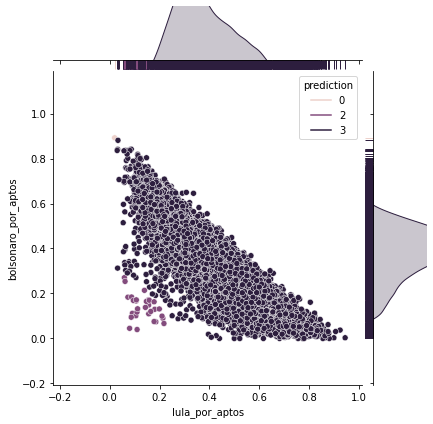

In [ ]:
pdf = predictions.selectExpr("bolsonaro_por_aptos", "lula_por_aptos", "prediction").sample(withReplacement=False, fraction=0.1, seed=42).toPandas()
g = sns.jointplot(data=pdf, x="lula_por_aptos", y="bolsonaro_por_aptos", hue="prediction")
g.plot_joint(sns.kdeplot, zorder=0, levels=3)
g.plot_marginals(sns.rugplot, height=-.15, clip_on=False)

In [ ]:
pdf = predictions.filter("prediction = 0").selectExpr("bolsonaro_por_aptos", "lula_por_aptos", "modelo").sample(withReplacement=False, fraction=1.0, seed=42).toPandas()
g = sns.jointplot(data=pdf, x="lula_por_aptos", y="bolsonaro_por_aptos", hue="modelo")
g.plot_joint(sns.kdeplot, zorder=0, levels=3)
g.plot_marginals(sns.rugplot, height=-.15, clip_on=False)

In [ ]:
pdf = predictions.filter("prediction = 0").selectExpr("bolsonaro_por_aptos", "lula_por_aptos", "regiao").sample(withReplacement=False, fraction=0.1, seed=42).toPandas()
g = sns.jointplot(data=pdf, x="lula_por_aptos", y="bolsonaro_por_aptos", hue="regiao")
g.plot_joint(sns.kdeplot, zorder=0, levels=3)
g.plot_marginals(sns.rugplot, height=-.15, clip_on=False)

In [ ]:
pdf = predictions.filter("prediction = 0").selectExpr("bolsonaro_por_aptos", "lula_por_aptos", "emissao_bu_pos_encerramento").sample(withReplacement=False, fraction=0.1, seed=42).toPandas()
g = sns.jointplot(data=pdf, x="lula_por_aptos", y="bolsonaro_por_aptos", hue="emissao_bu_pos_encerramento")
g.plot_joint(sns.kdeplot, zorder=0, levels=3)
g.plot_marginals(sns.rugplot, height=-.15, clip_on=False)

In [ ]:
pdf = predictions.filter("prediction = 3").selectExpr("bolsonaro_por_aptos", "lula_por_aptos", "modelo_2020").sample(withReplacement=False, fraction=0.1, seed=42).toPandas()
g = sns.jointplot(data=pdf, x="lula_por_aptos", y="bolsonaro_por_aptos", hue="modelo_2020")
g.plot_joint(sns.kdeplot, zorder=0, levels=3)
g.plot_marginals(sns.rugplot, height=-.15, clip_on=False)

In [ ]:
pdf = predictions.filter("prediction = 1").selectExpr("bolsonaro_por_aptos", "lula_por_aptos", "lulavence").sample(withReplacement=False, fraction=0.1, seed=42).toPandas()
g = sns.jointplot(data=pdf, x="lula_por_aptos", y="bolsonaro_por_aptos", hue="lulavence")
g.plot_joint(sns.kdeplot, zorder=0, levels=3)
g.plot_marginals(sns.rugplot, height=-.15, clip_on=False)

In [ ]:
pdf = predictions.filter("prediction = 1").selectExpr("bolsonaro_por_aptos", "lula_por_aptos", "regiao").sample(withReplacement=False, fraction=0.1, seed=42).toPandas()
g = sns.jointplot(data=pdf, x="lula_por_aptos", y="bolsonaro_por_aptos", hue="regiao")
g.plot_joint(sns.kdeplot, zorder=0, levels=3)
g.plot_marginals(sns.rugplot, height=-.15, clip_on=False)

In [ ]:
pdf = predictions.filter("prediction = 1").selectExpr("bolsonaro_por_aptos", "lula_por_aptos", "modelo").sample(withReplacement=False, fraction=0.1, seed=42).toPandas()
g = sns.jointplot(data=pdf, x="lula_por_aptos", y="bolsonaro_por_aptos", hue="modelo")
g.plot_joint(sns.kdeplot, zorder=0, levels=3)
g.plot_marginals(sns.rugplot, height=-.15, clip_on=False)

In [ ]:
pdf = predictions.filter("prediction = 2").selectExpr("bolsonaro_por_aptos", "lula_por_aptos", "lulavence").sample(withReplacement=False, fraction=0.1, seed=42).toPandas()
g = sns.jointplot(data=pdf, x="lula_por_aptos", y="bolsonaro_por_aptos", hue="lulavence")
g.plot_joint(sns.kdeplot, zorder=0, levels=3)
g.plot_marginals(sns.rugplot, height=-.15, clip_on=False)

In [ ]:
pdf = predictions.filter("prediction = 2").selectExpr("bolsonaro_por_aptos", "lula_por_aptos", "regiao").sample(withReplacement=False, fraction=0.1, seed=42).toPandas()
g = sns.jointplot(data=pdf, x="lula_por_aptos", y="bolsonaro_por_aptos", hue="regiao")
g.plot_joint(sns.kdeplot, zorder=0, levels=3)
g.plot_marginals(sns.rugplot, height=-.15, clip_on=False)

In [ ]:
pdf = predictions.filter("prediction = 3").selectExpr("bolsonaro_por_aptos", "lula_por_aptos", "lulavence").sample(withReplacement=False, fraction=0.1, seed=42).toPandas()
g = sns.jointplot(data=pdf, x="lula_por_aptos", y="bolsonaro_por_aptos", hue="lulavence")
g.plot_joint(sns.kdeplot, zorder=0, levels=3)
g.plot_marginals(sns.rugplot, height=-.15, clip_on=False)

In [ ]:
pdf = predictions.filter("prediction = 3").selectExpr("bolsonaro_por_aptos", "lula_por_aptos", "regiao").sample(withReplacement=False, fraction=0.1, seed=42).toPandas()
g = sns.jointplot(data=pdf, x="lula_por_aptos", y="bolsonaro_por_aptos", hue="regiao")
g.plot_joint(sns.kdeplot, zorder=0, levels=3)
g.plot_marginals(sns.rugplot, height=-.15, clip_on=False)

## DIFERENÇAS ENTRE L E B CONSIDERANDO ALGUMAS VARIÁVEIS

Vamos analisar considerando:

* Grupo do cluster
* Modelo 2020
* Modelos de urna
* Emissão do BU mais de 10 minutos após encerramento
* Urna de contingência
* lulavence
* empate

In [ ]:
#Cria a view p 
predictions.createOrReplaceTempView("p")

In [ ]:
# Urnas com mais de 95% aptos L

spark.sql('''
            SELECT zona, secao, local_votacao, endereco, cidade, regiao, uf,
            lula, bolsonaro, abstencoes, aptos, abstencoes_por_aptos, brancos, nulos FROM p 
            where lula_por_aptos between 0.0 and 1.0 and prediction != 3 and modelo_2020 = 0
            ORDER BY lula_por_aptos DESC
            LIMIT 100000
            ''').toPandas().plot(kind="scatter", x="lula", y="bolsonaro")

In [ ]:
# Diferenças entre L e B por cluster

spark.sql('''
            SELECT prediction,
            sum(lula), sum(bolsonaro), 
            sum(lula) - sum(bolsonaro) as dif_abs, 
            round(sum(lula) / sum(bolsonaro) - 1, 2) as dif_rel 
            FROM p 
            GROUP BY prediction
            ORDER BY dif_rel DESC
            ''').toPandas()

In [ ]:
# Diferenças entre L e B por modelo_2020
spark.sql('''
            SELECT modelo_2020,
            sum(lula), sum(bolsonaro), 
            sum(lula) - sum(bolsonaro) as dif_abs, 
            round(sum(lula) / sum(bolsonaro) - 1, 2) as dif_rel
            FROM p 
            GROUP BY modelo_2020
            ORDER BY dif_rel DESC
            ''').toPandas()

In [ ]:
# Diferenças entre L e B por modelo de urna
spark.sql('''
            SELECT modelo,
            sum(lula), sum(bolsonaro), 
            sum(lula) - sum(bolsonaro) as dif_abs, 
            round(sum(lula) / sum(bolsonaro) - 1, 2) as dif_rel
            FROM p 
            WHERE modelo != 1
            GROUP BY modelo
            ORDER BY dif_rel DESC
            ''').toPandas()

In [ ]:
# Diferenças entre L e B nas seções onde o BU foi emitido 
# após o horário de encerramento padrão com tolerância de 10 minutos

spark.sql('''
            SELECT emissao_bu_pos_encerramento,
            sum(lula), sum(bolsonaro), 
            sum(lula) - sum(bolsonaro) as dif_abs, 
            round(sum(lula) / sum(bolsonaro) - 1, 2) as dif_rel
            FROM p 
            GROUP BY emissao_bu_pos_encerramento
            ORDER BY dif_rel DESC
            ''')\
            .toPandas()

In [ ]:
# Diferenças entre L e B por urna de contingência

spark.sql('''
            SELECT urna_contingencia,
            sum(lula), sum(bolsonaro), 
            sum(lula) - sum(bolsonaro) as dif_abs, 
            round(sum(lula) / sum(bolsonaro) - 1, 2) as dif_rel
            FROM p 
            GROUP BY urna_contingencia
            ORDER BY dif_rel DESC
            ''')\
            .toPandas()

In [ ]:
# Diferenças entre L e B por lulavence

spark.sql('''
            SELECT lulavence,
            sum(lula), sum(bolsonaro), 
            sum(lula) - sum(bolsonaro) as dif_abs, 
            round(sum(lula) / sum(bolsonaro) - 1, 2) as dif_rel
            FROM p 
            GROUP BY lulavence
            ORDER BY dif_rel DESC
            ''')\
            .toPandas()

In [ ]:
# Diferenças entre L e B por bolsonarovence

spark.sql('''
            SELECT bolsonarovence,
            sum(lula), sum(bolsonaro), 
            sum(bolsonaro) - sum(lula) as dif_abs, 
            round(sum(bolsonaro) / sum(lula) - 1, 2) as dif_rel
            FROM p 
            GROUP BY bolsonarovence
            ORDER BY dif_rel DESC
            ''')\
            .toPandas()

In [ ]:
# Diferenças entre L e B por empate

spark.sql('''
            SELECT empate,
            sum(lula), sum(bolsonaro), 
            sum(lula) - sum(bolsonaro) as dif_abs, 
            round(sum(lula) / sum(bolsonaro) - 1, 2) as dif_rel
            FROM p 
            GROUP BY empate
            ORDER BY dif_rel DESC
            ''')\
            .toPandas()

In [ ]:
# Diferenças entre L e B por regiao

spark.sql('''
            SELECT regiao,
            sum(lula), sum(bolsonaro), 
            sum(lula) - sum(bolsonaro) as dif_abs, 
            round(sum(lula) / sum(bolsonaro) - 1, 2) as dif_rel
            FROM p 
            GROUP BY regiao
            ORDER BY dif_rel DESC
            ''')\
            .toPandas()

In [ ]:
# Diferenças entre L e B por estado

spark.sql('''
            SELECT uf,
            sum(lula), sum(bolsonaro), 
            sum(lula) - sum(bolsonaro) as dif_abs, 
            round(sum(lula) / sum(bolsonaro) - 1, 2) as dif_rel
            FROM p 
            GROUP BY uf
            ORDER BY dif_rel DESC
            ''')\
            .toPandas()

In [ ]:
spark.sql('''
            SELECT ROUND(sum(lula) / sum(aptos), 2) as lula_por_aptos, 
            ROUND(sum(bolsonaro) / sum(aptos), 2) as bolsonaro_por_aptos,
            ROUND ((sum(lula) / sum(aptos)) - (sum(bolsonaro) / sum(aptos)),2) as dif,
            modelo_2020
            FROM p
            GROUP BY modelo_2020
            ORDER BY dif DESC
''').toPandas()

In [ ]:
spark.sql('''
            SELECT ROUND(sum(lula) / sum(aptos), 2) as lula_por_aptos, 
            ROUND(sum(bolsonaro) / sum(aptos), 2) as bolsonaro_por_aptos,
            ROUND ((sum(lula) / sum(aptos)) - (sum(bolsonaro) / sum(aptos)),2) as dif,
            modelo
            FROM p
            GROUP BY modelo
            ORDER BY dif DESC
''').toPandas()

In [ ]:
spark.sql('''
            SELECT IF(dt_abertura < '2022-10-30 08:00:00', 1, 0) as abertura_antes_inicio,
            sum(lula), sum(bolsonaro), 
            sum(lula) - sum(bolsonaro) as dif_abs, 
            round(sum(lula) / sum(bolsonaro) - 1, 2) as dif_rel
            FROM p 
            WHERE regiao != 'ZZ'
            GROUP BY abertura_antes_inicio
            ORDER BY dif_rel DESC
''').toPandas()

In [ ]:
spark.sql('''
            SELECT max(cidade) as cidade, max(uf) as uf, max(zona) as zona, count(1) as total, sum(aptos) as aptos, 
            sum(if(modelo_2020 = 1, 1, 0)) as modelo2020,
            sum(if(modelo_2020 =0, 1, 0)) as nao2020,
            sum(lula) as l, sum(bolsonaro) as b, 
            sum(lula) - sum(bolsonaro) as dif_abs, 
            round(sum(lula) / sum(bolsonaro) - 1, 2) as dif_rel
            FROM p 
            GROUP BY zona_id
            HAVING aptos <= 50000 AND modelo2020 > 0 and nao2020 > 0
            ORDER BY total DESC
''').toPandas()

In [ ]:
spark.sql('''
            SELECT modelo,
            sum(lula), sum(bolsonaro), 
            sum(lula) - sum(bolsonaro) as dif_abs, 
            round(sum(lula) / sum(bolsonaro) - 1, 2) as dif_rel,
            count(1) as total_secoes
            FROM p 
            WHERE zona = 172 and cidade = 'REGISTRO' and uf = 'SP'
            GROUP BY modelo
            ORDER BY dif_rel DESC
''').toPandas()

In [ ]:
spark.sql('''
            SELECT IF(dt_abertura < '2022-10-30 07:00:00', 1, 0) as abertura_antes_inicio,
            sum(lula), sum(bolsonaro), 
            sum(lula) - sum(bolsonaro) as dif_abs, 
            round(sum(lula) / sum(bolsonaro) - 1, 2) as dif_rel
            FROM p 
            WHERE regiao != 'ZZ'
            GROUP BY abertura_antes_inicio
            ORDER BY dif_rel DESC
''').toPandas()

In [ ]:
# Armazena XLSX do cluster 0
#predictions.filter("prediction = 0").toPandas().to_excel(path + "/UrnasGrupo0.xlsx")

In [ ]:
# Armazena XLSX do cluster 1
#predictions.filter("prediction = 1").toPandas().to_excel(path + "/UrnasGrupo1.xlsx")

In [ ]:
# Armazena XLSX do cluster 2
#predictions.filter("prediction = 2").toPandas().to_excel(path + "/UrnasGrupo2.xlsx")

In [ ]:
# Armazena XLSX do cluster 3
#predictions.filter("prediction = 3").toPandas().to_excel(path + "/UrnasGrupo3.xlsx")

In [ ]:
# Armazena o dataframe com os clusters

#predictions.repartition(1).write.csv(path + "/Votacao/v2t_csv/", sep=";", mode="overwrite", header=True)
predictions.write.parquet(path + "/Votacao/v2t_parquet/", mode="overwrite")

In [ ]:
# Armazena o dataframe vm  em CSV

vm.repartition(1).write.csv(path + "/Votacao/v2t_csv/", sep=";", mode="overwrite", header=True)


In [ ]:
# Encerra a sessão e destrói o cache
#spark.stop()

# CONCLUSÃO

Os grupos 0 e 1 apresentam algumas seções anômalas que podem ser visualizadas nos gráficos e nos números. 

Essas mesmas urnas já foram encontradas em diversas análises com outras técnicas e recortes. 

O fator das anomalias não pode ser facilmente explicado, podendo variar muito as causas disso. Certamente esse tipo de análise pode permitir uma investigação mais profunda do processo eleitoral brasileiro.

Espero que você tenha ganho algum conhecimento com este notebook e que possa continuar analisando os dados com os arquivos gerados.

Boa sorte!

In [ ]:
!sleep 3600